In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil
sys.path.append('../')
from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2MASS Uniformity Test

NYU value added catalog 

In [77]:
def K_correction(twomass):
    
    twomass_kcorected = twomass['K_M_K20FE'] - 0.367 * twomass['EBV'] 
    twomass = rf.append_fields(twomass,'K_M_K20FE_correc',twomass_kcorected)
    twomass_kcorected = twomass['J_M_K20FE'] - 0.367 * twomass['EBV'] 
    twomass = rf.append_fields(twomass,'J_M_K20FE_correc',twomass_kcorected)
    twomass_kcorected = twomass['H_M_K20FE'] - 0.367 * twomass['EBV'] 
    twomass = rf.append_fields(twomass,'H_M_K20FE_correc',twomass_kcorected)

    return twomass

In [96]:
def add_ebv_column(twomass):

    HealInds = hpRaDecToHEALPixel(twomass['RA'], twomass['DECL'], nside=  512, nest= False)
    twomass = rf.append_fields(twomass,'HEALIndex',HealInds,dtypes=HealInds.dtype)

    reddening_nest = esutil.io.read('/n/des/lee.5922/data/2mass_cat/lambda_sfd_ebv.fits', ensure_native=True)
    reddening_ring = hp.reorder(reddening_nest['TEMPERATURE'], inp='NEST', out='RING')
    reddening = rotate_hp_map(reddening_ring, coord = ['C', 'G'])

    import pandas as pd
    left = pd.DataFrame( {'RA' : twomass['RA'] ,'DEC' : twomass['DECL'], 'PIXEL': twomass['HEALIndex']})
    hpind = np.arange(hp.nside2npix(512))
    right = pd.DataFrame( {'SFD' : reddening}, index = hpind )
    result = left.join(right, on = 'PIXEL')     

    twomass = rf.append_fields(twomass,'EBV', result['SFD'].values)
    return twomass
    #fitsio.write('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', twomass)

In [92]:
nyu_cat = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_catalog.fits')
sdss_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_sdss_spectro.fits')
twomass_spec = esutil.io.read('/n/des/lee.5922/data/NYU_value_added_cat/object_twomass.fits', ensure_native=True)

In [98]:
twomass_spec = add_ebv_column(twomass_spec)
twomass_spec = K_correction(twomass_spec)

In [78]:
twomass = esutil.io.read('/n/des/lee.5922/data/2mass_cat/fp_2mass.fp_xsc9864_k20mag_ebv.fits', upper=True, ensure_native=True)
nanmask = ((~np.isnan(twomass['K_M_I20C'])) & (~np.isnan(twomass['J_M_K20FE'])) 
           & (~np.isnan(twomass['K_M_K20FE']))& (~np.isnan(twomass['H_M_K20FE'])))
twomass = twomass[nanmask]
twomass_kcorected = twomass['K_M_I20C'] - 0.367 * twomass['EBV'] 
twomass = rf.append_fields(twomass,'K_M_I20C_correc',twomass_kcorected)

twomass = K_correction(twomass)
reliable_mask = ((twomass['EBV'] < 0.05/0.367 ))# & (twomass['K_M_I20C_correc'] < 13.85) )
twomass = twomass[reliable_mask]
#twomass = reddening_mask(cat = twomass, nside_out = NSIDE)
#twomass_galmap = making_healpix_density_map(cat = twomass, nside = NSIDE, nest = False)

In [104]:
twomass_gold = Cuts.keepGoodRegion(twomass[twomass['DEC']<-3.0])
twomass_ngc = boss_mask(cat=twomass, area='NGC', nside_out = 1024)
twomass_sgc = boss_mask(cat=twomass, area='SGC', nside_out = 1024)

In [105]:
def twomass_color_dist(twomass, bins = None):
    NM,_ = np.histogram( twomass['K_M_K20FE_correc'], bins=bins, normed=True)
    NJ,_ = np.histogram( twomass['J_M_K20FE_correc'], bins=bins, normed=True)
    NH,_ = np.histogram( twomass['H_M_K20FE_correc'], bins=bins, normed=True)
    return NM, NJ, NH

In [102]:
twomass_jk = construct_jk_catalog( twomass, njack = 10 )

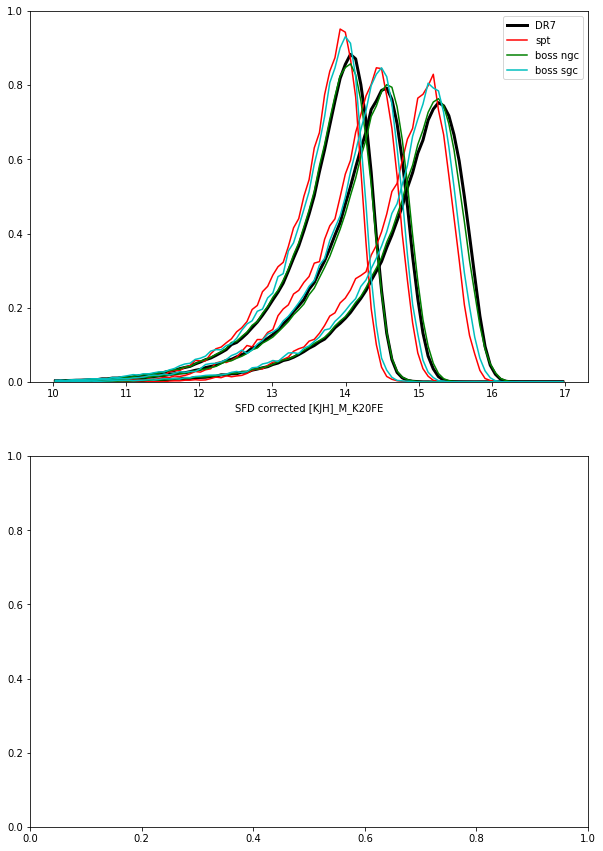

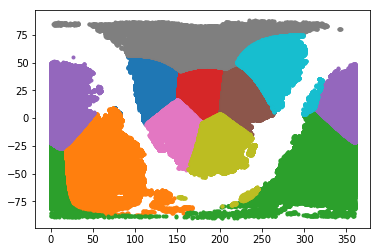

In [113]:
kbin, kstep = np.linspace(10,17,100,retstep=True)
kcen= kbin[:-1] + kstep/2.

NM, NJ, NH = twomass_color_dist(twomass_spec, bins = kbin)
fig, (ax, ax2) = plt.subplots(2,1,figsize = (10,15))

ax.plot(kcen ,NM, 'k-', linewidth = 3)
ax.plot(kcen ,NJ, 'k-', linewidth = 3)
ax.plot(kcen ,NH, 'k-', linewidth = 3, label = 'DR7')

NM2, NJ2, NH2 = twomass_color_dist(twomass_gold, bins = kbin)
ax.plot(kcen ,NM2, color = 'red')
ax.plot(kcen ,NJ2, color = 'red')
ax.plot(kcen ,NH2, color = 'red', label='spt')

NM2, NJ2, NH2 = twomass_color_dist(twomass_ngc, bins = kbin)
ax.plot(kcen ,NM2, color = 'green')
ax.plot(kcen ,NJ2, color = 'green')
ax.plot(kcen ,NH2, color = 'green', label = 'boss ngc')

NM2, NJ2, NH2 = twomass_color_dist(twomass_sgc, bins = kbin)
ax.plot(kcen ,NM2, color = 'c')
ax.plot(kcen ,NJ2, color = 'c')
ax.plot(kcen ,NH2, color = 'c', label = 'boss sgc')

ax.legend()
ax.set_xlabel('SFD corrected [KJH]_M_K20FE')

"""
for i,jk in enumerate(twomass_jk) : 
    
    NM2, NJ2, NH2 = twomass_color_dist(jk, bins = kbin)
    ax.plot(kcen ,NM2, alpha = 0.1, color = 'grey')
    ax.plot(kcen ,NJ2, alpha = 0.1, color = 'grey')
    ax.plot(kcen ,NH2, alpha = 0.1, color = 'grey')
"""
ax.set_ylim(0,)
fig, ax = plt.subplots()

for i,jk in enumerate(twomass_jk) : 
    ax.plot(jk['RA'], jk['DEC'], '.')

In [1140]:
def z_gaussian(mu, sigma, bins):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

def z_gaussians(A, bins):

    sigma1 = 0.07
    sigma2 = 0.2
    mu1 = 0.59
    mu2 = 0.35
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

In [1147]:
Nz = np.column_stack(( zbin[:-1], N1, N2, N3, N4 ))
#np.savetxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz', Nz)
Nz = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/zdistris/twomass.nz')
Nz_cmass,_ = np.histogram( cmass_spec['Z'], bins=zbin, normed=True)

def Pnz(z, i):
    import scipy
    zcenter = np.insert( Nz[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz[:, i], 0, 0)
    pnz = scipy.interpolate.interp1d(zcenter, nz)
    return pnz(z)

Nz_cmass = np.column_stack(( zbin[:-1], N_cmass ))
def Pnz_cmass(z, i):
    import scipy
    zcenter = np.insert( Nz_cmass[:,0] + 0.005, 0, 0)
    nz = np.insert( Nz_cmass[:, i], 0, 0)
    pnz = scipy.interpolate.interp1d(zcenter, nz)
    return pnz(z)

def Pnz_dmass(z, i, A=0.8):  
    """
    Two Gaussian Mixture
    A*G1 + (1-A)*G2
    """
    sigma1 = 0.07
    sigma2 = 0.2
    mu1 = 0.59
    mu2 = 0.35
    g1 = 1./(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu1)**2 / (2 * sigma1**2))
    g2 = 1./(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (z - mu2)**2 / (2 * sigma2**2))
    
    return A*g1 + (1.0-A) * g2

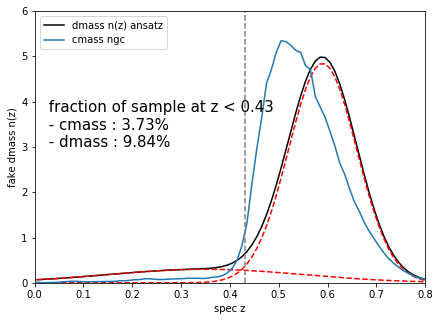

In [1170]:
zbin, dz = np.linspace(0.0, 10.0, 1001, retstep=True)

fig, ax = plt.subplots(1,1,figsize = (7,5))

A = 0.85
ax.plot(zcenter, Pnz_dmass(zcenter,0,A=A), 'k-', label = 'dmass n(z) ansatz')
ax.plot(zcenter, A*z_gaussian(0.59, 0.07, zcenter), 'r--')
ax.plot(zcenter, (1.-A)*z_gaussian(0.35, 0.2, zcenter), 'r--')
ax.plot(zcenter, Pnz_cmass(zcenter,1), label = 'cmass ngc')
#N_cmass,_, _ = ax.hist( cmass_spec['Z'], bins=zbin, alpha = 0.5, normed=True, label = 'cmass ngc')
ax.axvline(x = 0.43, color='grey', linestyle='--')

dmass_frac = scipy.integrate.simps(Pnz_dmass(zcenter, 1, A = A)[:43], dx = dz )*100
cmass_frac = scipy.integrate.simps(Pnz_cmass(zcenter, 1)[:43], dx = dz )*100

ax.text(0.02, 3, ' fraction of sample at z < 0.43 \n - cmass : {:0.2f}% \n - dmass : {:0.2f}%'\
        .format(cmass_frac, dmass_frac), fontsize = 15)
ax.set_xlabel('spec z')
ax.set_ylabel('fake dmass n(z)')
ax.set_xlim(0, 0.8)
ax.set_ylim(0,6)
ax.legend(loc='best')

In [1149]:
import camb
from camb import model, initialpower

In [1150]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=68.81, ombh2=0.022158939348000003, omch2 =0.116902635602, omk=0.0, YHe = 0.245341, tau = 0.08,
                   num_massive_neutrinos = 1)
pars.set_dark_energy()
pars.InitPower.set_params(As=2.26e-9, ns=0.96)
results = camb.get_results(pars)

#units
cc = 299792.5
H0 = 100 
coverH0 = cc/H0
h0 = pars.H0/100.

# matter power spectrum interpolation
PK = camb.get_matter_power_interpolator\
(pars, zmin=0, zmax=10, nz_step = 101, nonlinear=True, 
 hubble_units=True, k_hunit=True, kmax=5000, log_interp = True)
    

In [846]:
from numpy import log, exp, cos, pi

def chi(a):
    return results.comoving_radial_distance(1./a -1.)/coverH0 * h0

def Ea(a):
    return results.hubble_parameter(1./a - 1.) * 1./pars.H0
    
def WgalA(a, indz):
    """
    2MASS kernel
    """
    z = 1./a -1.
    wgal  = b_avg[indz-1] * Pnz(z, indz) * Ea(a)
    return wgal

def WgalB(a, indz):
    """
    cmass kernel
    """
    z = 1./a -1.
    b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_cmass[indz-1] * Pnz_cmass(z, 1) * Ea(a)
    return wgal
    #return 1.

def Wgal_dmass(a, indz, A=0.8):
    """
    dmass kernel
    Assume b = 2.0 for all z range.
    """
    z = 1./a -1.
    b_cmass = [2.0, 2.0, 2.0, 2.0]
    wgal  = b_avg[indz-1] * Pnz_dmass(z, 1, A = A) * Ea(a)
    return wgal

def dchi_da(a):
    return 1./Ea(a)/a**2

def Pdelta(k, a):
    k = k/coverH0
    return PK.P(1./a -1., k)/(coverH0)**3

def int_for_Cl(ell, a, indz):
    
    k =  (ell+0.5) *1./chi(a)
    Pm =  np.array([Pdelta(k[i], a[i]) for i in range(k.size)])
    return WgalA(a,indz) * WgalB(a,indz) * dchi_da(a)/chi(a)**2 * Pm
 
def C_ell( ell, indz ):
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
        
    Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return Cl


def w_matter(theta, a):
    
    ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
    
    k =  (ellbin+0.5) *1./chi(a)
    Pm = Pdelta(k,a)
    
    w = cl_to_w(ellbin, Pm, theta)
    return w

def w_project( theta, indz ):
    """
    w(theta). 
    Default kernel is cmass_kernel * 2mass_kernel
    """
    
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    wprojt = np.array([w_matter(theta, a) for a in acenter])
    int_for_res = WgalA(acenter,indz) * WgalB(acenter,indz) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def w_project_A( theta, indz,  A=0.8 ):
    """
    w(theta) for varying A in dmass nz ansatz
    Default kernel is 2MASS kernel*DMASS kernel
    """
    from scipy.integrate import simps 
    zmin = 0
    zmax = 10.0    
    abin, da = np.linspace(1./(1+zmax), 1./(1+zmin), 100, retstep = True)
    acenter = abin[:-1] + da/2.
           
    wprojt = np.array([w_matter(theta, a) for a in acenter])
    int_for_res = WgalA(acenter,indz) * Wgal_dmass(acenter,indz, A=A) * dchi_da(acenter)/chi(acenter)**2
    
    wtheta = [simps(int_for_res * wprojt[:,i], dx = da) for i in range(theta.size)]
    
    #Cl = simps(int_for_Cl(ell, acenter, indz), dx = da)
    return np.array(wtheta)


def dw(a, indz):
    return WgalA(a, indz)* WgalB(a, indz) *dchi_da(a)/chi(a)**2 * w_matter(theta, a)

In [714]:
def log_interp(x, y):
    """
    Log interpolation
    """
    s = scipy.interpolate.interp1d(log(x), log(y))
    x0 = x[0]
    y0 = y[0]
    x1 = x[-1]
    y1 = y[-1]

    def interpolator(xi):
        w1 = xi == 0
        w2 = (xi > 0) & (xi <= x0)
        w3 = xi >= x1
        w4 = ~ (w1 | w2 | w3)

        y = np.zeros_like(xi)
        y[w2] = y0 * (x0 / xi[w2])
        y[w3] = y1 * (x1 / xi[w3])**3
        y[w4] = exp(s(log(xi[w4])))
        return y
    return interpolator

def cl_to_w(ell, c_ell, theta):
    """
    Fourier transform
    """
    theta = np.radians(theta / 60)
    cl_interp = log_interp(ell, c_ell)
    ell_max = int(ell.max())
    ell_max_integral = 200000
    ell_sample = np.arange(ell_max_integral) * 1.0
    c_ell_sample = np.zeros(ell_max_integral)
    c_ell_sample = cl_interp(ell_sample)
#    for i,ell_i in enumerate(ell_sample):
#        c_ell_sample[i] = cl_interp(ell_i)

    f = (2 * ell_sample + 1) / (4 * pi)
    w = np.zeros_like(theta)
    for i, t in enumerate(theta):
        p_ell, _ = scipy.special.lpn(ell_max_integral - 1, cos(t))
        w[i] = (f * p_ell * c_ell_sample).sum()
    return w

In [495]:
ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
Celllist1 = np.array([C_ell(ell, 1) for ell in ellbin])
Celllist2 = np.array([C_ell(ell, 2) for ell in ellbin])
Celllist3 = np.array([C_ell(ell, 3) for ell in ellbin])
Celllist4 = np.array([C_ell(ell, 4) for ell in ellbin])

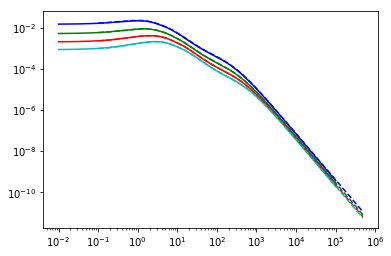

In [496]:
galaxy_cl_like = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/twomass/galaxy_cl_fourier')
ell_like = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/twomass/galaxy_cl_fourier.ell')

galaxy_cl = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/Agnes/camb_baseline_3nu/galaxy_cl/bin_1_1.txt')

ell_sis = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/Agnes/camb_baseline_3nu/galaxy_cl/ell.txt')

fig, ax = plt.subplots()
ax.loglog(ellbin, Celllist1, 'b-' )
ax.loglog(ellbin, Celllist2, 'g-' )
ax.loglog(ellbin, Celllist3, 'r-' )
ax.loglog(ellbin, Celllist4, 'c-' )
#ax.loglog(ell_sis, galaxy_cl)
ax.loglog(ell_like, galaxy_cl_like[:400, 1], 'b--')
ax.loglog(ell_like, galaxy_cl_like[400:800, 1], 'g--')
ax.loglog(ell_like, galaxy_cl_like[800:1200, 1], 'r--')
ax.loglog(ell_like, galaxy_cl_like[1200:, 1], 'c--')

In [497]:
theta = np.logspace(np.log10(2.5), np.log10(250), 20)
wtheta1 = cl_to_w(ellbin, Celllist1, theta)
wtheta2 = cl_to_w(ellbin, Celllist2, theta)
wtheta3 = cl_to_w(ellbin, Celllist3, theta)
wtheta4 = cl_to_w(ellbin, Celllist4, theta)

In [498]:
wproj1 = w_project(theta, 1)
wproj2 = w_project(theta, 2)
wproj3 = w_project(theta, 3)
wproj4 = w_project(theta, 4)

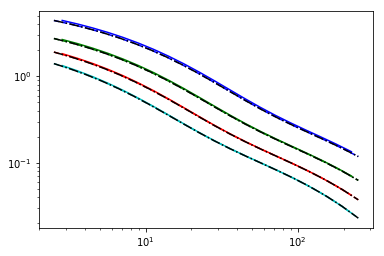

In [499]:
wtheta_like = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/twomass/wtheta')
theta_like = np.genfromtxt('/n/des/lee.5922/programs/cosmolike/MG_musigma/\
datav/cosmolike_cosmosis/twomass/wtheta.theta')

fig, ax = plt.subplots()
#ax.loglog(ell_sis, galaxy_cl)
ax.loglog(theta_like, wtheta_like[720:740, 1], 'b-')
ax.loglog(theta_like, wtheta_like[740:760, 1], 'g-')
ax.loglog(theta_like, wtheta_like[760:780, 1], 'r-')
ax.loglog(theta_like, wtheta_like[780:, 1], 'c-')

ax.loglog(theta, wtheta1,'b--')
ax.loglog(theta, wtheta2,'g--')
ax.loglog(theta, wtheta3,'r--')
ax.loglog(theta, wtheta4,'c--')

ax.loglog(theta, wproj1,'k-.')
ax.loglog(theta, wproj2,'k-.')
ax.loglog(theta, wproj3,'k-.')
ax.loglog(theta, wproj4,'k-.')

### cmass vs 2mass forecast

In [526]:
ellbin = np.logspace(np.log10(1e-2), np.log10(100000), 400)
Cell1 = np.array([C_ell(ell, 1) for ell in ellbin])
Cell2 = np.array([C_ell(ell, 2) for ell in ellbin])
Cell3 = np.array([C_ell(ell, 3) for ell in ellbin])
Cell4 = np.array([C_ell(ell, 4) for ell in ellbin])

theta = np.logspace(np.log10(2.5), np.log10(250), 20)
wtheta1 = cl_to_w(ellbin, Cell1, theta)
wtheta2 = cl_to_w(ellbin, Cell2, theta)
wtheta3 = cl_to_w(ellbin, Cell3, theta)
wtheta4 = cl_to_w(ellbin, Cell4, theta)

In [939]:
wproj1 = w_project(theta, 1)
wproj2 = w_project(theta, 2)
wproj3 = w_project(theta, 3)
wproj4 = w_project(theta, 4)

In [974]:
wprojA1 = w_project_A(theta, 1, A=bestfit_A[0])
wprojA2 = w_project_A(theta, 2, A=bestfit_A[1])
wprojA3 = w_project_A(theta, 3, A=bestfit_A[2])
wprojA4 = w_project_A(theta, 4, A=bestfit_A[3])

1.6332801536228228 2.7090539643758835
3.80927991458841 0.3518931731846213
2.0345937449631433 0.971313988207888
9.580036925564992 0.45045922397403537


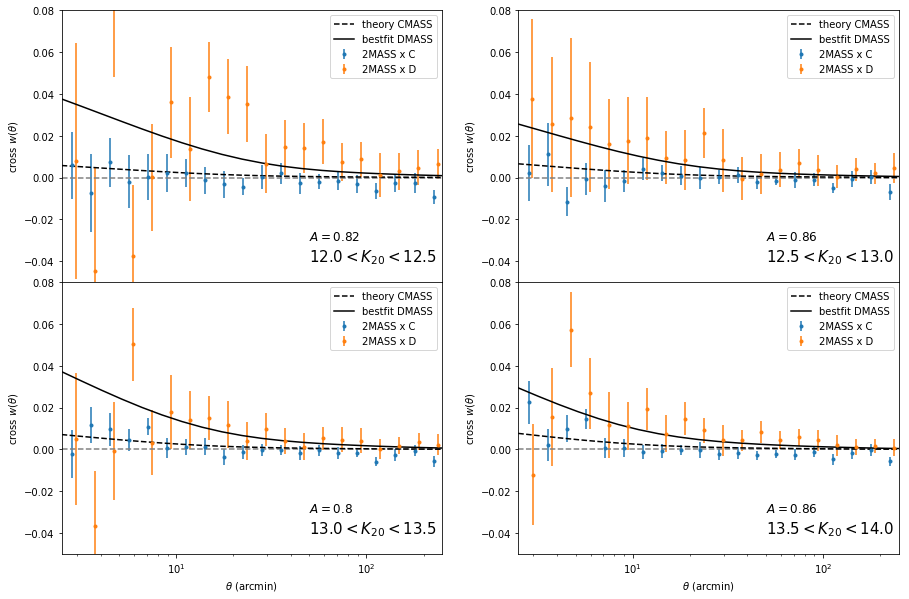

In [1152]:
#meanr, xi, xi_err = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_k1.txt', unpack=True)
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_midz_no1.txt',unpack=True)


label = [r'$12.0 < K_{20} < 12.5$', r'$12.5 < K_{20} < 13.0$',\
         r'$13.0 < K_{20} < 13.5$', r'$13.5 < K_{20} < 14.0$']

wproj = [wproj1,wproj2,wproj3,wproj4 ]
wprojA = [wprojA1,wprojA2,wprojA3,wprojA4 ]
pbcmass = 1.0
#fig, ax = plt.subplots(4, 1, figsize = (7,20))
fig, ax = plt.subplots(2, 2, figsize = (15,10))
ax = ax.ravel()
for i in range(1, 5):
    ax[i-1].axhline(y=0, color='grey', linestyle='--')
    
    meanr, xi, xi_err = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no2_k{}.txt'.format(i), unpack=True)
    meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_k{}.txt'.format(i),unpack=True)
    
    cov = np.loadtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no2_k{}.cov'.format(i))
    cov2 = np.loadtxt('../data_txt/acf_cross_2mass_x_dmass_spt_k{}.cov'.format(i))
    invcov = np.linalg.inv(cov)
    invcov2 = np.linalg.inv(cov2)
    
    diffv = wproj[i-1] - xi
    chi2 = np.dot( np.dot( diffv, invcov), diffv)
    
    diffv2 = wprojA[i-1] - xi2
    chi22 = np.dot( np.dot( diffv2[3:], invcov2[3:,3:]), diffv2[3:])
    
    print chi2/20., chi22/17
    
    ax[i-1].errorbar(meanr*60, xi, yerr = xi_err, fmt = '.', label='2MASS x C')
    ax[i-1].errorbar(meanr2*60*1.05, xi2, yerr = xi_err2, fmt = '.', label='2MASS x D')
    ax[i-1].semilogx(theta, wproj[i-1],'k--', label = 'theory CMASS')
    ax[i-1].semilogx(theta, wprojA[i-1],'k-', label = 'bestfit DMASS')
    ax[i-1].text(50, -0.03, r'$A = {:02}$'.format(bestfit_A[i-1]), fontsize = 12)
    ax[i-1].text(50, -0.04, label[i-1], fontsize = 15)

    #ax.semilogx(theta, pbcmass * wproj1,'-', color = ax.lines[1].get_color())
    #ax.semilogx(theta, pbcmass * wproj2,'-', color = ax.lines[2].get_color())
    #ax.semilogx(theta, pbcmass * wproj3,'-', color = ax.lines[3].get_color())
    #ax.semilogx(theta, pbcmass * wproj4,'-', color = ax.lines[4].get_color())
    ax[i-1].set_ylim(-0.05, 0.08)
    ax[i-1].set_xlim(2.5, 250)
    ax[i-1].set_xlabel(r'$\theta$ (arcmin)')
    ax[i-1].set_ylabel(r'cross $w(\theta)$')
    ax[i-1].legend(loc='best')

fig.subplots_adjust(wspace=0.2, hspace=0)

In [1153]:
def chisquare(indz):
    
    datav = np.genfromtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no2_k{}.txt'.format(indz))[:,1]
    cov = np.genfromtxt('../data_txt/acf_cross_2mass_x_cmass_ngc_no2_k{}.cov'.format(indz))
    covinv = np.linalg.inv(cov)
    
    theta = np.logspace(np.log10(2.5), np.log10(250), 20)
    As = np.linspace(0.9, 1.0, 11)
    
    i=0
    chi2 = []
    for A in As : 
        modelv = w_project_A( theta, indz,  A=A )
        vdiff = (datav - modelv)[0:]
        res = np.dot(np.dot( vdiff, covinv[0:,0:] ), vdiff)
        
        if i != 0 : 
            if res > chi2[i-1] : return As[i-1]
        chi2.append(res)
        print A, res, i+1,'/', As.size, '\r',
        i+=1
    fig, ax = plt.subplots()
    ax.plot(As, chi2)
    
    ind = np.argmin(chi2)
    return As[ind]

In [969]:
bestfit_A1 = chisquare(1)
bestfit_A2 = chisquare(2)
bestfit_A3 = chisquare(3)
bestfit_A4 = chisquare(4)

In [1154]:
print bestfit_A1, bestfit_A2, bestfit_A3, bestfit_A4

0.97 1.0 0.95 0.9
